In [1]:
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np


1-2. 내가 직접 만드는 강아지 고양이 분류기.  
(1) 이미지 분류 문제
자, 바로 실습을 시작해 보겠습니다. 앞으로 이미지를 넣었을 때 강아지인지, 고양이인지 분류하는 모델을 만들 것입니다.

텐서플로우(TensorFlow)를 활용해서 이미지를 분류할 수 있는 모델을 설계해 보겠습니다.

In [2]:
import tensorflow as tf
print(tf.__version__)
#2.17.1

2.6.0


1-3. 내가 직접 만드는 강아지 고양이 분류기.   

(2) 모델이 학습하려면? 공부할 데이터를 줘야지!
모델 학습을 위한 데이터셋(dataset) 준비하기
가장 먼저 강아지와 고양이 이미지 데이터가 필요하겠죠! 텐서플로우에서 제공하는 데이터셋을 사용할 것입니다.

클라우드 사용자는 tensorflow_datasets 패키지가 이미 설치되어 있으므로 바로 패키지를 로드해 보겠습니다.

In [3]:
import tensorflow_datasets as tfds

tfds.__version__
#4.9.7

'4.4.0'

tensorflow_datasets는 텐서플로우가 제공하는 데이터셋 모음집입니다. 우리에게 필요한 강아지와 고양이 이미지뿐만 아니라 음성 데이터셋, 이미지 데이터셋, 텍스트 데이터셋 등 방대한 종류의 데이터셋을 제공하죠.

다음 링크에서 tensorflow_datasets에 관한 세부 내용을 확인할 수 있습니다.

https://www.tensorflow.org/datasets/catalog/overview

데이터는 약 2만 장으로 이루어져 있음
그럼 데이터를 가져와 보죠. 다음 코드를 실행시켜봅시다.

In [36]:
!mkdir -p ~/aiffel/flowers/FlowerImages
#!ln -s ~/data/* ~/aiffel/flowers/

# TensorFlow Datasets를 사용하여 데이터 다운로드
# 'data_dir'을 지정해 데이터를 구글 드라이브 경로에 저장
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    download=True,
    data_dir='~/aiffel/flowers/',
    with_info=True,
    as_supervised=True
)


INFO:absl:Load dataset info from /aiffel/aiffel/flowers/tf_flowers/3.0.1
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Reusing dataset tf_flowers (/aiffel/aiffel/flowers/tf_flowers/3.0.1)
INFO:absl:Constructing tf.data.Dataset tf_flowers for split ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], from /aiffel/aiffel/flowers/tf_flowers/3.0.1


In [37]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


각 데이터셋의 형태가 잘 출력되었군요.

모든 데이터셋은 (image, label)의 형태를 가집니다. ((None, None, 3), ())가 이를 나타내죠. 여기에서 앞에 있는 (None, None, 3)은 image의 shape를, 뒤의 ()는 정답 카테고리인 label의 shape를 의미합니다.

이미지는 (height, width, channel)로 3차원 데이터이기 때문에 (None, None, 3)과 같이 나타났습니다. 이때 height와 width가 None으로 나타난 이유는 무엇일까요?

잠시 뒤에 확인하겠지만, 모든 이미지의 크기가 전부 다르기 때문입니다. 정해져 있지 않은 사이즈이기 때문에 None으로 나타낸 거죠.

그렇다면 3이라는 숫자는 무엇을 나타낼까요?

이미지의 색을 표현하는 채널의 수를 나타냅니다. 컬러 이미지의 경우, 색은 RGB의 세 가지 색 조합으로 나타낼 수 있다는 것을 알고 있을 겁니다. 이미지를 컴퓨터상에 나타낼 때, 각 픽셀(pixel)의 색은 RGB의 세 가지 색의 조합으로 나타나기 때문에 컬러 이미지는 항상 3개의 채널을 가지고 있어야 하죠.
반면, 흑백 이미지는 white/black만 나타내면 되므로 단 하나의 채널만 있어도 충분합니다.

label은 특정 이미지가 강아지인지, 혹은 고양이인지를 나타내는 단일 값입니다. 단순히 1차원의 숫자 하나로 표현될 수 있기 때문에 차원이 따로 나타나지 않았습니다.

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("슝~")

슝~


raw_train 안에 있는 데이터를 확인해 보기 위해 tf.data.Dataset에서 제공하는 take라는 함수를 사용해 보겠습니다. 이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수입니다.

그럼 바로 다음 코드를 실행 시켜 보세요.

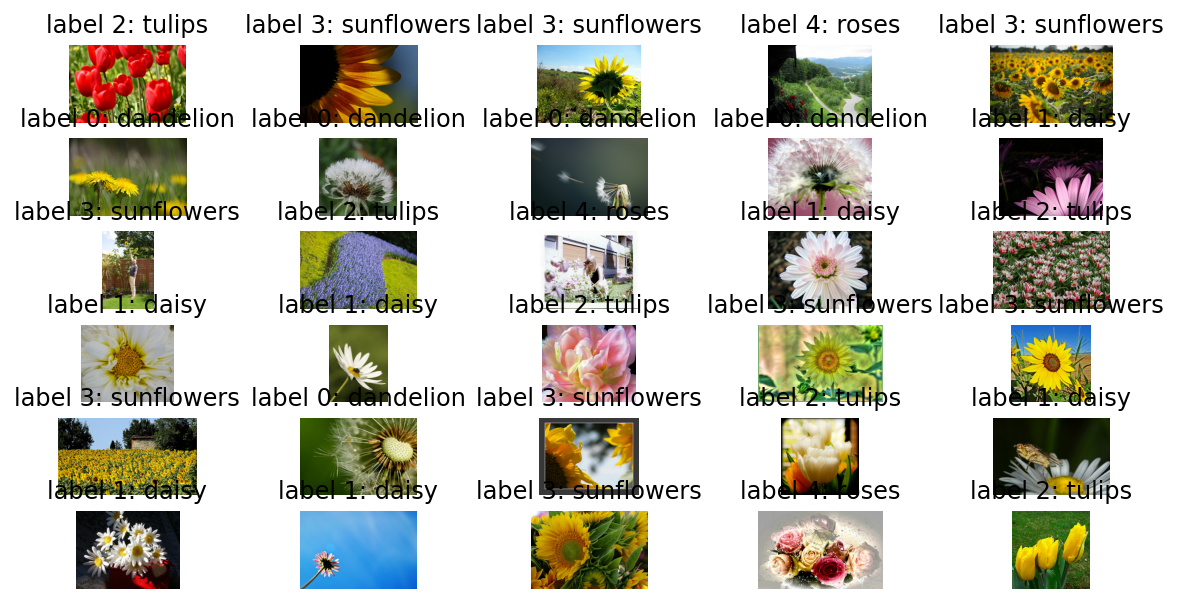

In [9]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(30)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(6, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

10장의 사진을 확인해 보니 귀여운 강아지와 고양이 이미지들이 잘 섞여 있네요!

강아지는 label 1로, 고양이는 label 0으로 설정되어 있군요. 앞서 설명했듯 이미지의 사이즈는 전부 제각각이네요. 모델을 학습시킬 때에는 이미지 사이즈를 통일시켜 주는 작업을 해야할 것 같습니다.

format_example() 함수를 이용해 이미지를 같은 포맷으로 통일 시켜 봅시다.

아래 코드는 이미지의 사이즈를 160x160 픽셀로 통일시킬 뿐만 아니라, 각 픽셀값의 scale을 수정해주는 역할도 합니다.

‍🌈 간단 상식 - 타입캐스팅(Type Casting)
형변환이라고도 불리는 타입캐스팅은 다른 데이터 타입으로 형(타입)을 바꿔주는 것을 의미합니다. 정수형을 실수형으로 바꾸기 위해 float()를 사용하는 것이 타입캐스팅의 한 예입니다.






In [10]:
IMG_SIZE = 224 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

print("슝~")

슝~


그럼 이제 format_example() 함수를 raw_train, raw_validation, raw_test 에 map() 함수로 적용시켜서 원하는 모양의 train, validataion, test 데이터셋으로 변환해 보겠습니다. 리스트 원소 전체에 동일한 변환 함수를 for 문을 사용하지 않고 손쉽게 적용하게 해주는 map 함수에 대해서 빠르게 아래 코드로 알아봅시다.

map은 리스트의 요소를 지정된 함수로 처리해주는 함수입니다.






In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)
# IMG_SIZE를 160으로 지정해 줌으로써, 모든 이미지의 크기를 (160, 160, 3)으로 통일시켰습니다.

<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


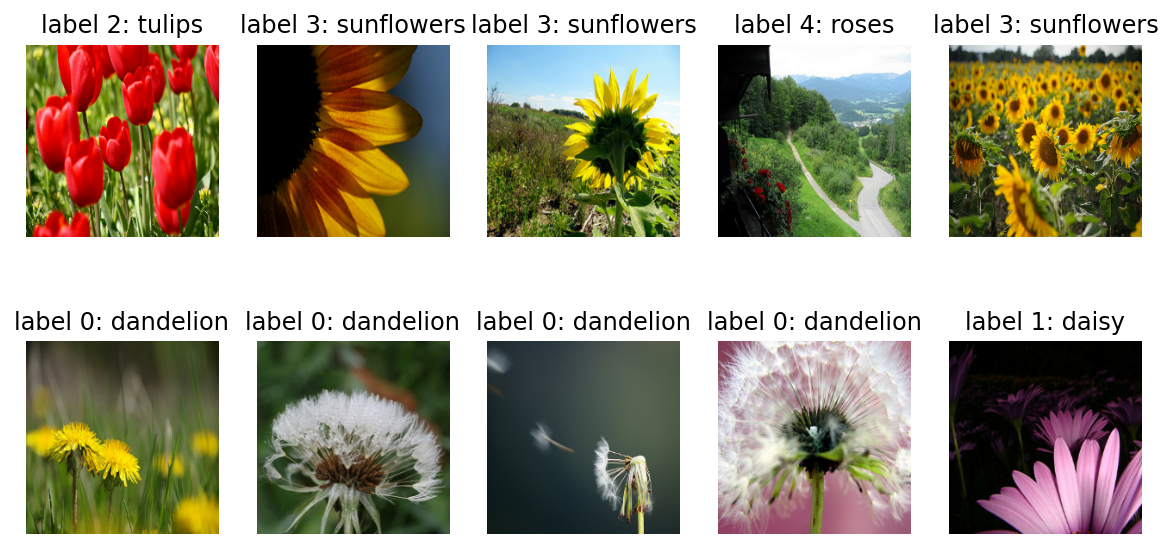

In [12]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')
    # 다시 이미지를 시각적으로 확인해 다시 확인해 보니 모든 이미지의 크기가 균일해진 것을 확인할 수 있습니다.

1-5. 내가 직접 만드는 강아지 고양이 분류기  

(4) 데이터가 준비되었으니, 이제 모델을 만들어보자  

텐서플로우를 활용해 모델 구조 설계하기  

이미지 준비가 끝났으니 이 이미지들로 학습시킬 모델을 만들어봅시다!

먼저 모델 생성에 필요한 다음 함수들을 가져오겠습니다. 아래에 있는 함수들은 앞으로 어떤 딥러닝 모델을 만들더라도 거의 항상 만나게 되는 친구들이니, 이름을 잘 익혀두는 것이 좋습니다.

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout

print("슝~")

슝~


위의 두 줄은 각각 models와 layers에서 가져왔다는 차이가 있군요.

models는 모델 그 자체를 구축하기 위한 함수들을 포함하고 있고, layers에는 모델의 구성 요소인 여러 가지 종류의 레이어(layer), 즉 "층"이라는 함수들을 가지고 있죠. Sequential은 말 그대로 "연속적인" 모델을 쌓기 위한 함수입니다. Sequential 함수 안에 연속적으로 여러 가지 레이어들이 들어가죠.

위에서 가져온 함수들로 바로 모델을 만들어보며 더 구체적으로 살펴보겠습니다.






In [14]:
# Pre-trained ResNet50 모델을 불러옵니다.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) #최상위 분류 레이어를 제외하고, 기본적인 특성 추출 부분만 불러옵니다.
base_model.trainble = False           # 모델층의 동결

94781440/94765736 [==============================] - 0s 0us/step


정확히는 몰라도 어디선가 본 것 같은 느낌이죠?!

앞으로 딥러닝에서의 레이어 라는 개념을 더 자세하게 고민해 보고 공부하겠지만, 딥러닝 모델은 언제나 위와 같이 여러 개의 층을 쌓은 형태로 구성됩니다. Conv2D, MaxPooling2D, Flatten, Dense라는 네 가지 종류의 레이어를 사용했네요.

filters=16 / 필터는 입력 이미지의 패턴(특징)을 학습하며, 필터 수가 많을수록 다양한 특징 학습
kernel_size=3 / 커널은 입력 데이터에서 특정 영역을 슬라이딩하며 특징을 추출
padding='same' / 입력과 동일한 크기의 출력을 유지하기 위해 제로 패딩을 추가합니다.
activation='relu' / 활성화 함수를 지정. 음수를 0으로 변환하고 양수는 그대로 전달하는 활성화 함수. 활성화 함수는 모델이 복잡한 패턴을 학습하도록 함
input_shape=(160, 160, 3) / 입력 데이터의 형상(크기, (height, width, channels) 형식) 지정

In [18]:
x = base_model.output
x = GlobalAveragePooling2D()(x)    # 경량화와 빠른 학습, 적은 파라미터로 처리
#x = Flatten()(base_model.output)  # 많은 파라미터 계산, 고급 모델에서 정밀한 분류시 유리
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x) # 해파리를 6개의 클래스로 분류
model = Model(base_model.input, outputs)
model.summary()
'''
첫 번째 차원은 데이터의 개수를 나타냅니다. 여기서는 정해지지 않은 수라는 None 기호로 표시되었네요. None은 배치(batch) 사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타냅니다.
데이터 하나의 크기는 (height, width, channel)로 3차원이죠. 6개의 레이어를 지나면서 height와 width는 점점 작아지고, channel은 점점 커지다가, flatten 계층을 만나 25,600(20x20x64)이라는 하나의 숫자로, 즉 1차원으로 shape가 줄어듭니다.
앞의 모델과 같이 점점 작은 feature map이 출력되다가, Flatten과 Dense 레이어를 거쳐 데이터가 1차원으로 줄어드는 네트워크는 CNN(Convolutional Neural Net)을 사용한 딥러닝 모델의 가장 대표적인 형태입니다.
이 전체 과정을 그림으로 확인해 보죠.
아래의 링크 참고.
https://ieeexplore.ieee.org/document/726791
'''

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

'\n첫 번째 차원은 데이터의 개수를 나타냅니다. 여기서는 정해지지 않은 수라는 None 기호로 표시되었네요. None은 배치(batch) 사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타냅니다.\n데이터 하나의 크기는 (height, width, channel)로 3차원이죠. 6개의 레이어를 지나면서 height와 width는 점점 작아지고, channel은 점점 커지다가, flatten 계층을 만나 25,600(20x20x64)이라는 하나의 숫자로, 즉 1차원으로 shape가 줄어듭니다.\n앞의 모델과 같이 점점 작은 feature map이 출력되다가, Flatten과 Dense 레이어를 거쳐 데이터가 1차원으로 줄어드는 네트워크는 CNN(Convolutional Neural Net)을 사용한 딥러닝 모델의 가장 대표적인 형태입니다.\n이 전체 과정을 그림으로 확인해 보죠.\n아래의 링크 참고.\nhttps://ieeexplore.ieee.org/document/726791\n'

1-6. 내가 직접 만드는 강아지 고양이 분류기  
(5) 모델아 모델아, 데이터를 먹고 똑똑해지렴!  
모델 compile 완료 후 학습시키기  
그럼 이제 모델을 학습시켜보겠습니다!

모델이 학습하는 데에 필요한 "학습률"(learning_rate)이라는 파라미터를 0.0001로 설정해주고, 모델을 compile 하여 학습할 수 있는 형태로 변환해주도록 하겠습니다.

In [19]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

print("슝~")

슝~


compile을 하기 위해서는 세 가지가 필요합니다. 바로 optimizer, loss, metrics 라는 친구들입니다.

optimizer는 학습을 어떤 방식으로 시킬 것인지 결정합니다. 어떻게 최적화시킬 것인지를 결정하기 때문에 최적화 함수라고 부르기도 합니다.
loss는 모델이 학습해나가야 하는 방향 을 결정합니다. 이 문제에서는 모델의 출력은 입력받은 이미지가 고양이인지 강아지인지에 대한 확률분포로 두었으므로, 입력 이미지가 고양이(label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에 가까워지도록 하는 방향을 제시합니다.
metrics는 모델의 성능을 평가하는 척도 입니다. 분류 문제를 풀 때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall) 등이 있습니다. 여기서는 정확도를 사용했습니다.
참고 링크
https://sumniya.tistory.com/26

이 세 가지를 모두 정해주면서 compile을 마무리하면 모델은 학습될 준비가 마무리된 것입니다.

그렇다면 이제는 모델을 학습시킬 데이터를 준비해야겠죠!

한 스텝에 학습시킬 데이터의 개수인 BATCH_SIZE와 학습 데이터를 적절히 섞어줄 SHUFFLE_BUFFER_SIZE를 설정해주겠습니다.

In [20]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
print("슝~")

슝~


BATCH_SIZE에 따라 32개의 데이터를 랜덤으로 뿌려줄 train_batches, validation_batches, test_batches를 만들어 주겠습니다. train_batches는 모델이 끊임없이 학습될 수 있도록 전체 데이터에서 32개를 랜덤으로 뽑아 계속 제공해 줄 것입니다.

In [21]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
print("슝~")

슝~


In [22]:
#train_batches에서 하나의 batch만 꺼내 데이터를 확인해볼까요?
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape
# image_batch의 shape는 [32, 160, 160, 3]을, label_batch의 shape는 [32]를 나타냅니다.

(TensorShape([32, 224, 224, 3]), TensorShape([32]))

In [26]:
from tensorflow import keras

EPOCHS = 30
callbacks = [

    keras.callbacks.ModelCheckpoint(
    'flower1.h5',  # 모델 저장 경로
    monitor='val_loss',    # 검증 손실을 기준으로 저장
    save_best_only=True,  # 가장 좋은 모델만 저장
    verbose=1)             # 저장 시 메시지 출력
]
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
                    callbacks=callbacks)
# 한 에포크당 10분 걸림 주의, 실제 할 때는 GPU로 변경하기

Epoch 1/30
92/92 [==============================] - 55s 384ms/step - loss: 0.4516 - accuracy: 0.8426 - val_loss: 2.9288 - val_accuracy: 0.2425

Epoch 00001: val_loss improved from inf to 2.92880, saving model to flower1.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
92/92 [==============================] - 32s 345ms/step - loss: 0.1095 - accuracy: 0.9615 - val_loss: 2.1497 - val_accuracy: 0.2943

Epoch 00002: val_loss improved from 2.92880 to 2.14965, saving model to flower1.h5
Epoch 3/30
92/92 [==============================] - 33s 351ms/step - loss: 0.0535 - accuracy: 0.9809 - val_loss: 3.8282 - val_accuracy: 0.2561

Epoch 00003: val_loss did not improve from 2.14965
Epoch 4/30
92/92 [==============================] - 33s 349ms/step - loss: 0.0510 - accuracy: 0.9854 - val_loss: 2.3052 - val_accuracy: 0.5232

Epoch 00004: val_loss did not improve from 2.14965
Epoch 5/30
92/92 [==============================] - 33s 350ms/step - loss: 0.0311 - accuracy: 0.9922 - val_loss: 5.8079 - val_accuracy: 0.3787

Epoch 00005: val_loss did not improve from 2.14965
Epoch 6/30
92/92 [==============================] - 33s 351ms/step - loss: 0.0448 - accuracy: 0.9888 - val_loss: 4.0200 - val_accuracy: 0.6676

Epoch 00006: val_loss did not improve from 2

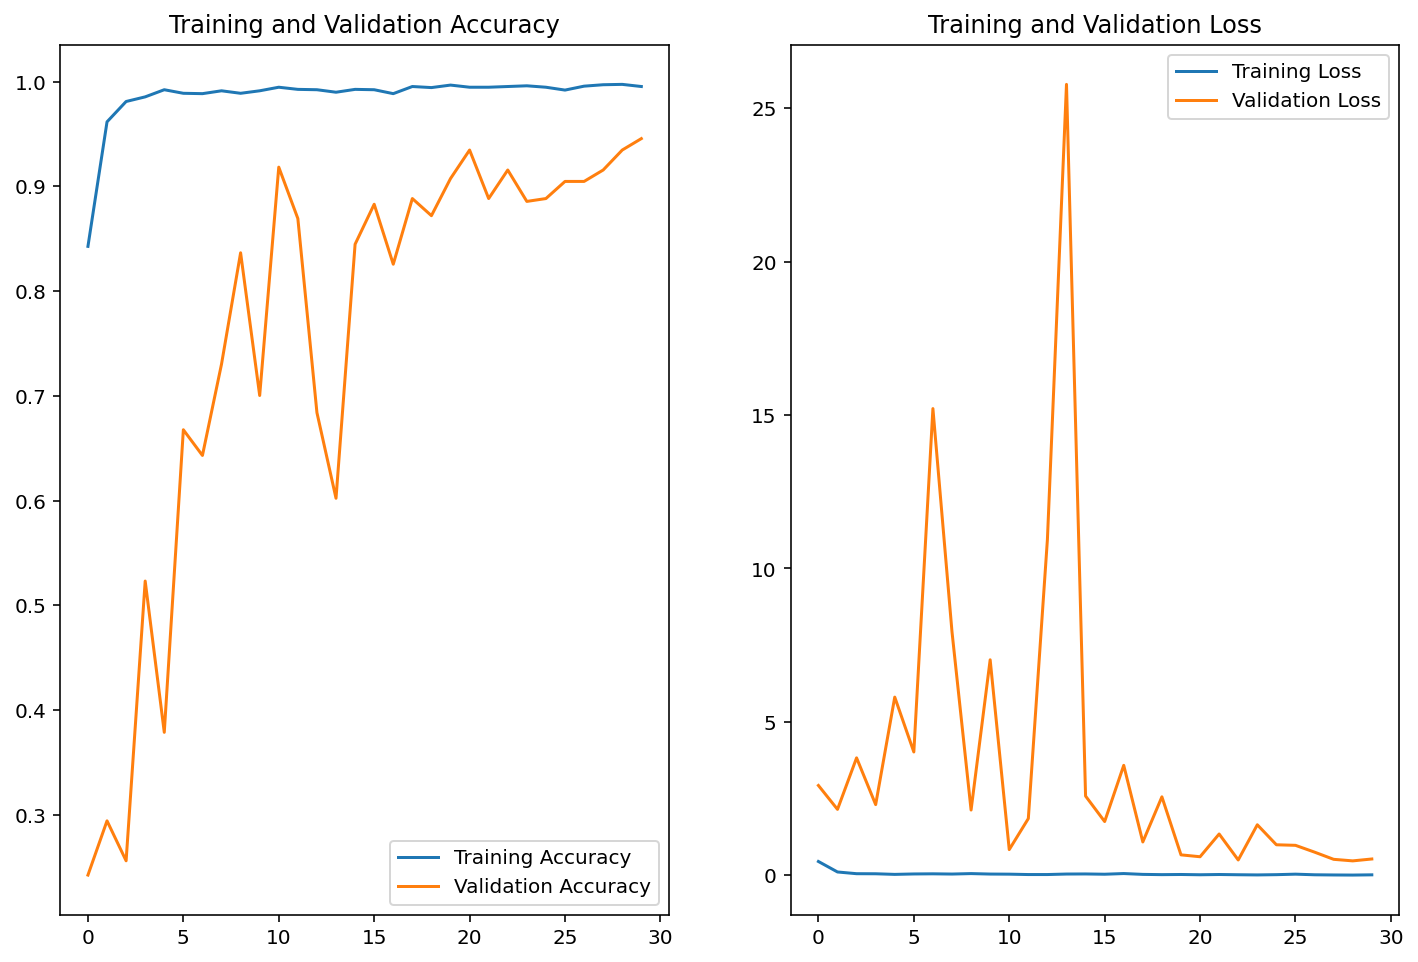

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# 정확도(accuracy)와 손실값(loss)에 대한 두 가지 그래프를 그려보았습니다. 두 그래프 모두 훈련 데이터셋에 대한 수치와 검증 데이터셋에 대한 수치를 나타냅니다.

In [28]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

array([[4.5997326e-13, 9.4915116e-09, 9.9999237e-01, 1.7776390e-09,
        7.6366123e-06],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 1.9434127e-12, 5.7588542e-18, 6.2887564e-13,
        2.0764416e-15],
       [2.0688173e-11, 6.9997582e-06, 9.9999297e-01, 2.2313362e-09,
        2.4831765e-08],
       [1.0000000e+00, 5.2654792e-09, 1.7544391e-11, 4.2774309e-10,
        4.7921707e-09],
       [1.0000000e+00, 1.4443784e-16, 1.1276574e-18, 1.5452760e-17,
        7.6290015e-20],
       [6.6488439e-16, 7.0528422e-14, 1.0000000e+00, 2.2898689e-16,
        6.4682162e-17],
       [3.1949325e-11, 1.0000000e+00, 2.9217358e-15, 6.3621824e-13,
        8.8974553e-13],
       [5.5827588e-33, 0.0000000e+00, 1.3839543e-35, 1.0000000e+00,
        0.0000000e+00],
       [1.0000000e+00, 4.7369318e-37, 0.0000000e+00, 5.0368728e-33,
        0.0000000e+00],
       [1.0000000e+00, 1.0073501e-32, 0.0000000e+00, 7.8282440e-32,
        0.00

predictions가 엄청난 소수점 값들로 이루어져 있군요. 이 값은 모델이 판단한 [고양이일 확률, 강아지의 확률]인데, [1.0, 0.0]에 가까울수록 label이 0인 고양이로, [0.0, 1.0]에 가까울수록 label이 1인 강아지로 예측했다고 볼 수 있습니다.

즉 고양이일 확률이 더 높으면 고양이로, 그렇지 않으면 강아지로 예측했다고 할 수 있겠군요.

prediction 값들을 실제 추론한 라벨(고양이:0, 강아지:1)로 변환해 보겠습니다. 실제로 모델이 각 이미지를 강아지라고 판단했는지, 고양이로 판단했는지 보기 위해서요!

In [29]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       1, 0, 1, 3, 1, 4, 4, 3, 0, 4])

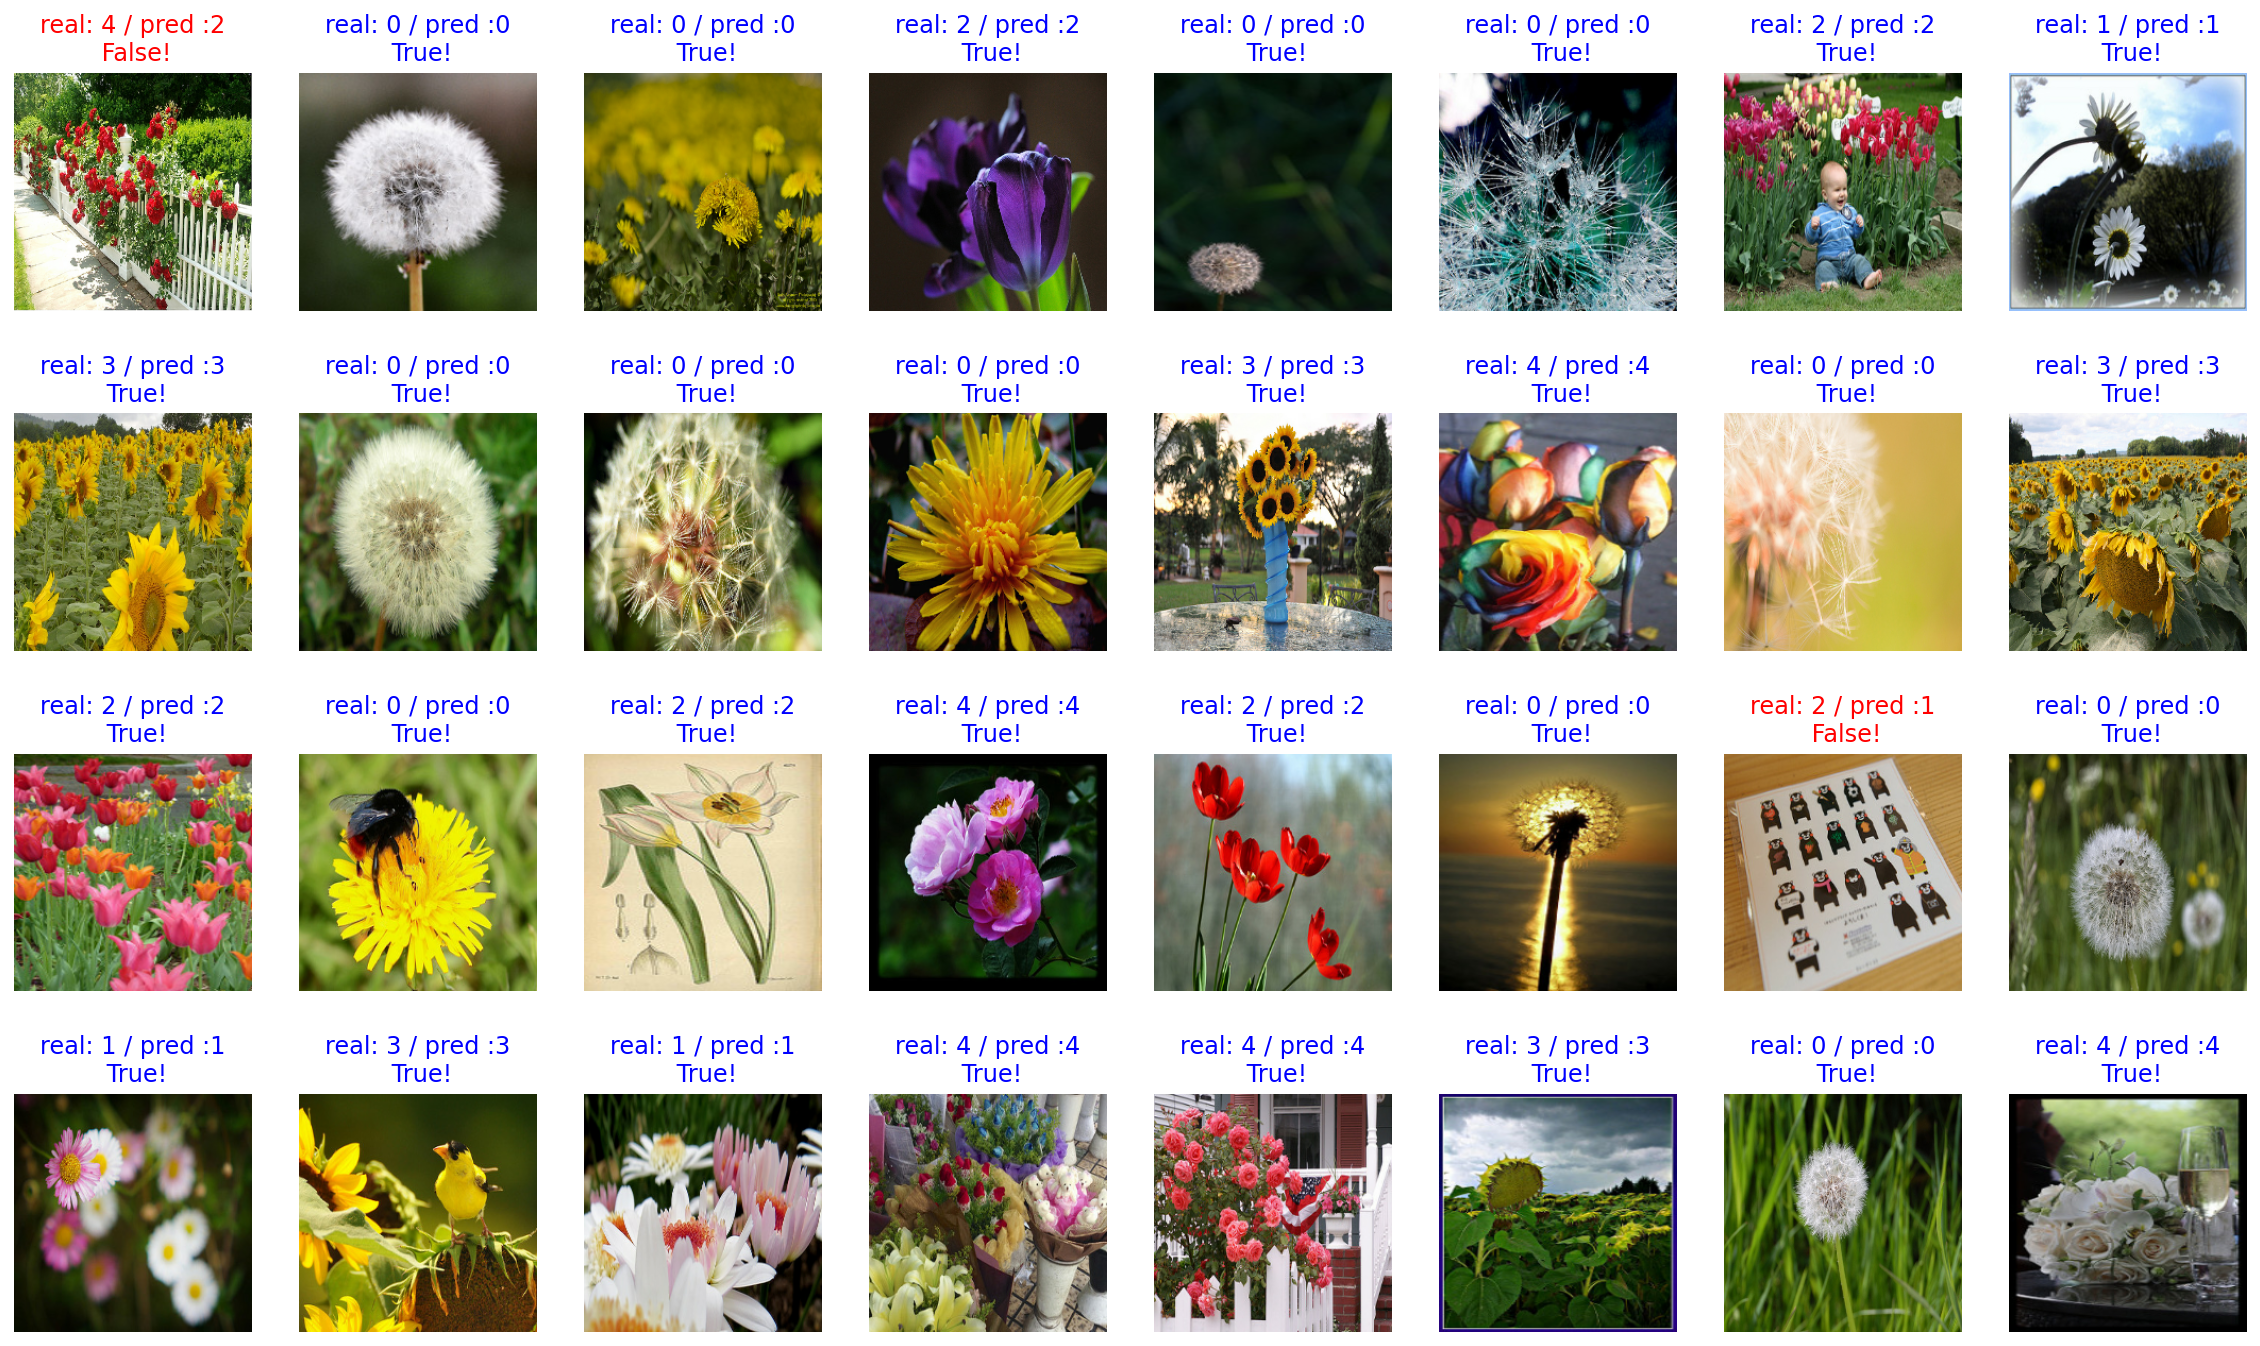

In [30]:
# 이제 32장의 image들과 32개의 label, 그리고 32개의 prediction을 얻었으니 각각을 시각화해서 확인하겠습니다.
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = np.all(label == prediction)
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

어떤가요?

대부분 맞았지만, 틀린 것도 종종 보입니다. 틀린 이미지들을 한 번 더 유심히 보세요. 모두 이해해주지는 못하더라도, 어딘가 다른 명확한 이미지들보다는 조금 어려웠을 수 있다는 생각이 들지 않나요?

위의 32개 이미지에 대해서는 예측(prediction)의 정확도(accuracy)가 몇일까요? 한번 위의 코드에서 필요한 부분만 빼내어, 직접 맞은 예측의 개수를 세는 코드를 만들어서 계산해 보세요!

In [32]:
count = 0  # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction:  # 레이블과 예측이 같은지 확인
        count += 1  # 맞춘 경우 카운트를 증가

# 정확도 출력
print(f'Accuracy: {count / 32 * 100:.2f}%')


Accuracy: 93.75%


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
import os
from sklearn.preprocessing import LabelEncoder
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

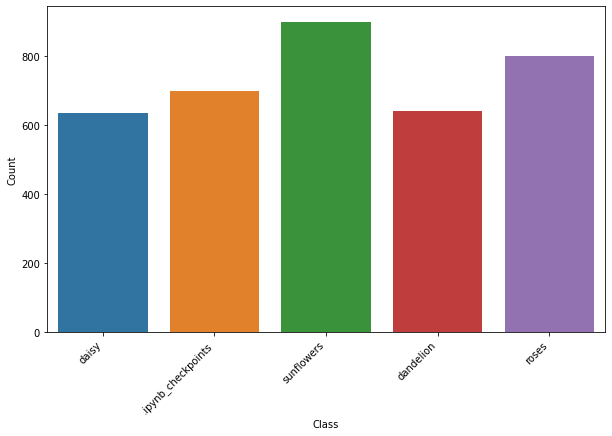

In [2]:
def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        classes.append(class_name)

        for filename in os.listdir(class_path):
            filepath = os.path.join(class_path, filename)
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (224, 224))
                img = img / 255.0
                images.append(img)
                labels.append(class_name)

    images = np.array(images)
    labels = label_encoder.fit_transform(labels) 

    return images, labels, classes

# Update the path to your dataset
data_directory = os.path.expanduser('~/aiffel/flowers/flower_photos')
images, labels, classes = load_data(data_directory)

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=[classes[label] for label in labels])  
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
classes = np.unique(classes)

In [3]:
# 이미지 증강
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader

# 데이터 타입 변환
X_train = (X_train * 255).astype('uint8')
X_test = (X_test * 255).astype('uint8')

# Transform 정의
transform_train = Compose([
    ToTensor(),  # PIL 이미지를 PyTorch 텐서로 변환
])
transform_test = Compose([
    ToTensor(),  # PIL 이미지를 PyTorch 텐서로 변환
])

# PyTorch TensorDataset으로 변환
train_data = [(transform_train(Image.fromarray(X_train[i])), y_train[i]) for i in range(len(X_train))]
test_data = [(transform_test(Image.fromarray(X_test[i])), y_test[i]) for i in range(len(X_test))]

# DataLoader 생성
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
